In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

from sdebridge import diffusion_bridge as db
from sdebridge import sdes

from sdebridge.utils import score_fn
from sdebridge.data_processing import sample_ellipse

from sdebridge.plotting import plot_single_trajectory
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
T=1.
Nt=100
dim=2
N = 11
sigma=1.0

forward_init = sample_ellipse(N)
forward_init = jnp.expand_dims(forward_init, axis=0)
bm_sde = sdes.brownian_sde(T, Nt, dim, N, sigma)

diffusion_.shape=(1, 11, 11)
eps.shape=(1, 11, 2)


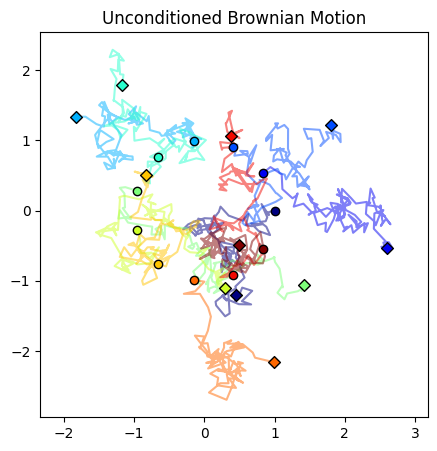

In [4]:
key = jax.random.PRNGKey(2)
forward_trajs = sdes.simulate_traj(bm_sde, forward_init, 2, key)
traj = forward_trajs[0].reshape((-1, N*dim))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")


In [5]:
from sdebridge.networks.score_unet import ScoreUNet

    
neural_net = ScoreUNet

network = {
    "output_dim": bm_sde.dim*bm_sde.N,
    "time_embedding_dim": 32,
    "init_embedding_dim": 32,
    "act_fn": "silu",
    "encoder_layer_dims": [64, 32, 16, 8],
    "decoder_layer_dims": [8, 16, 32, 64],
    "batchnorm": True,
}
    # "neural_net": ScoreUNet,
    # "network": {
    #     "output_dim": bm.sde.dim*bm.sde.n_bases,
    #     "time_embedding_dim": 128,
    #     "init_embedding_dim": 256,
    #     "act_fn": "gelu",
    #     "encoder_layer_dims": [256, 256, 256],
    #     "decoder_layer_dims": [256, 256, 256],
    #     "batchnorm": False,
    # },
    
training= {
    "batch_size": 100,
    "load_size": 5000,
    "num_epochs": 50,
    "learning_rate": 5e-3,
    "warmup_steps": 0,
}


target = sample_ellipse(N)
target = jnp.expand_dims(target, axis=0)
train_key = jax.random.split(key, 2)[0]
score_state_p = db.learn_p_score(bm_sde, target, train_key, **training, net=neural_net, network_params=network)

Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

scores.shape=(9900, 1, 11, 2), grads.shape=(9900, 1, 11, 2), covs.shape=(9900, 1, 11, 11)


Training: 100%|██████████| 50/50 [02:04<00:00,  2.48s/epoch, Epoch=50, loss=103196.8672]


In [10]:
initial_val = sample_ellipse(N, scale=2.0)
initial_val = jnp.expand_dims(initial_val, axis=0)
score_p = score_fn(score_state_p)
reverse_bm = sdes.reverse(bm_sde, score_p)
backward_trajs = sdes.simulate_traj(reverse_bm, initial_val, 2, train_key)


diffusion_.shape=(1, 11, 11)
eps.shape=(1, 11, 2)


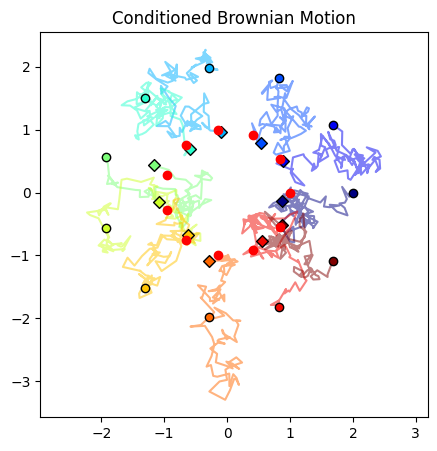

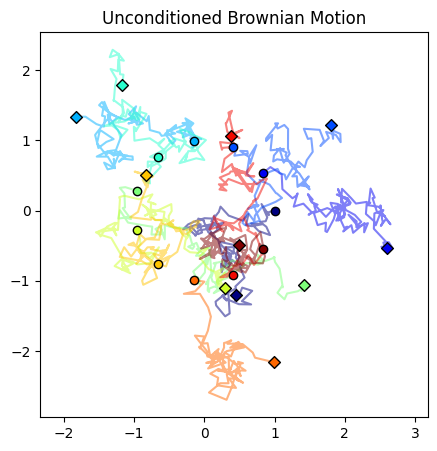

In [11]:
traj = backward_trajs[0].reshape((-1, N*dim))
plot_single_trajectory(traj, "Conditioned Brownian Motion")

plt.scatter(target[:, :, 0], target[:, :, 1], c='r', label="Target", zorder=3)
plt.show()

traj = forward_trajs[0].reshape((-1, N*dim))
plot_single_trajectory(traj, "Unconditioned Brownian Motion")